## Classifying Satelite Images

In [0]:
%reload_ext autoreload
%autoreload 2         
%matplotlib inline

In [4]:
from fastai.vision import *   ## connect to gdrive 
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/exercise-4'

Mounted at /content/gdrive


## Getting the data

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

download data from Kaggle datasets by executing the code below in your terminal

In [0]:
 #! {sys.executable} -m pip install kaggle --upgrade # install kaggle API

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
! mkdir -p ~/.kaggle/
! cp -r "$base_dir/kaggle.json" ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
 ! cp -r "$base_dir/train-jpg.tar" {path}
# train-jpg.tar.7z can't download using 'kaggle competition dowload' command in colab
# so I download this file from kaggle page 'https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data' and move path

# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}


In [0]:
!cp "$base_dir/train_v2.csv" {path}

In [0]:
#! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar | tar xf - -C {path.as_posix()} ## n unpack the data


## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [12]:
df = pd.read_csv(str(path)+'/train_v2.csv') ## csv includes list of folders for each label 
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.) ##   This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')  ## where the images come fro,
       .split_by_rand_pct(0.2) 
       .label_from_df(label_delim=' ')) ## create two different data sets to train 

In [0]:
data = (src.transform(tfms, size=128) ## transform the images to same size 
        .databunch().normalize(imagenet_stats)) 

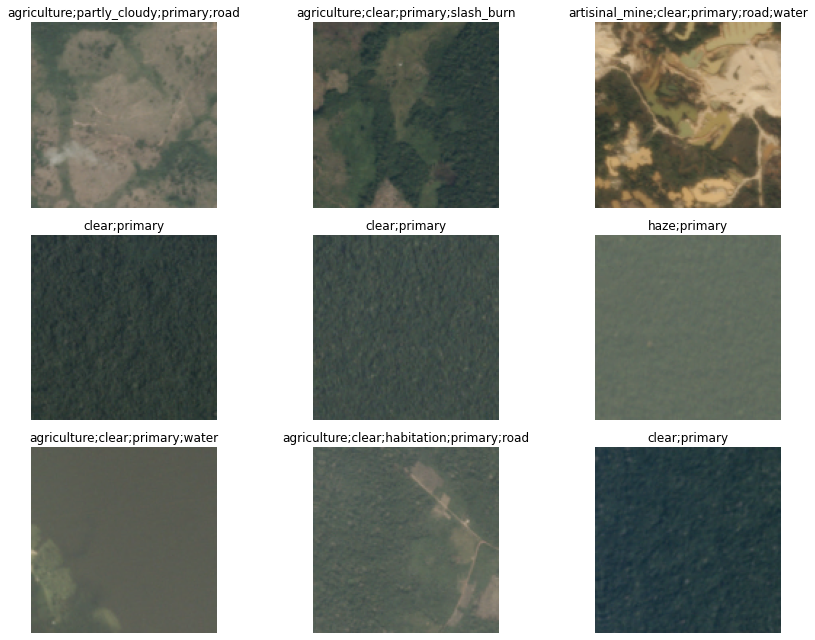

In [16]:
data.show_batch(rows=3, figsize=(12,9)) ## show the different labels separated by ;.

In [0]:
arch = models.resnet50  # use base architecture resnet 50 

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2) ## use accuracy_thresh instead of accuracy 
f_score = partial(fbeta, thresh=0.2)  ## each activation can be 0. or 1 
learn = cnn_learner(data, arch, metrics=[acc_02, f_score]) ## create a learner 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [19]:
learn.lr_find() # LR Finder to pick a good learning rate.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


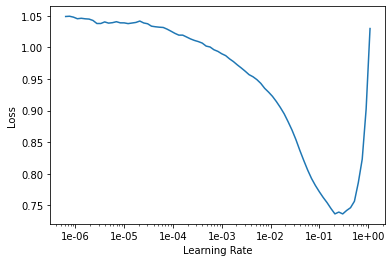

In [20]:
#@title
learn.recorder.plot()  # make a plot of lr 

In [0]:
lr = 0.01 ## select 0.01 as learning rate 

In [22]:
learn.fit_one_cycle(5, slice(lr)) ## train the model 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137838,0.112346,0.947302,0.903262,02:50
1,0.112536,0.097561,0.952680,0.916177,02:50
2,0.102417,0.091738,0.955673,0.921324,02:50
3,0.095003,0.087806,0.957555,0.924769,02:50
4,0.089668,0.086789,0.955927,0.925807,02:48


In [0]:
learn.save('stage-1-rn50')  ## save the weights 

...And fine-tune the whole model:

In [0]:
 learn.unfreeze()  ## unfreeze to train the model again 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


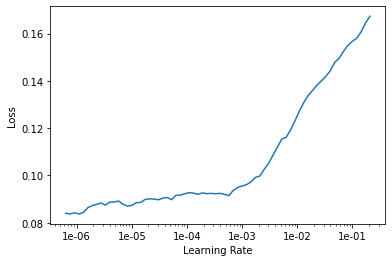

In [25]:
learn.lr_find()   ## find learning rate 
learn.recorder.plot() ## make a plot 

In [26]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) ## train again, with smaller learning rate 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098985,0.095768,0.952258,0.913524,02:53
1,0.094309,0.090028,0.957497,0.922405,02:53
2,0.090574,0.086014,0.956618,0.926659,02:52
3,0.087354,0.083078,0.958231,0.928784,02:53
4,0.081624,0.082777,0.958122,0.929028,02:52


In [0]:
learn.save('stage-2-rn50') ## save weight 

In [28]:
data = (src.transform(tfms, size=256)   ## transform but with size 256 
        .databunch().normalize(imagenet_stats))

learn.data = data  ## use the same model but replace the data with the new data bunch 
data.train_ds[0][0].shape  

torch.Size([3, 256, 256])

In [0]:
learn.freeze() ## freeze the model to find learning rate

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


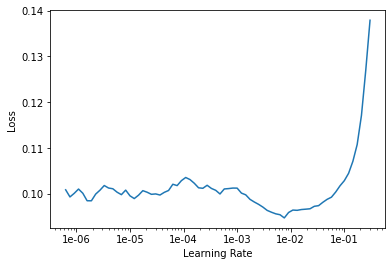

In [30]:
learn.lr_find()  ## find lr and plot them
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) ## train it again, but with even smaller learning rate

In [0]:
learn.recorder.plot_losses() ## we can see that resizing the image increases the accuracy 

In [0]:
learn.save('stage-2-256-rn50') # a guide, 50th place (out of 938 teams) on the private leaderboard was a score of 0.930.

In [0]:
learn.export()